In [121]:
import numpy as np
np.random.seed(2003)
import pandas as pd
from tqdm import tqdm

## 字符串处理工具包
import string
import re
import gensim
from collections import Counter
import pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.preprocessing import text, sequence 

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from functools import partial

import os 
import gc
from scipy.sparse import vstack  
import time
import datetime

import joblib

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
import seaborn as sns 
%matplotlib inline

In [122]:
path = 'D:\Learn File\配套代码_机器学习算法竞赛实战\书籍代码整理_完整版\第10章 阿里天池 全球城市计算AI挑战赛\input/'
NROWS = 300000
for i in tqdm(range(1, 26)):
    if i < 10:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv', nrows=NROWS)
    else:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv', nrows=NROWS)
    if i == 1:
        data = train_tmp
    else:
        data = pd.concat([data, train_tmp], axis=0, ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:22<00:00,  1.14it/s]


In [123]:
data.head()

,time,lineID,stationID,deviceID,status,userID,payType
0,2019-01-01 02:00:05,B,27,1354,0,D13f76f42c9a677c4add94d9e480fb5c5,3
1,2019-01-01 02:01:40,B,5,200,1,D9a337d37d9512184b8e3fd477934b293,3
2,2019-01-01 02:01:53,B,5,247,0,Dc9e179298617f40b782490c1f3e2346c,3
3,2019-01-01 02:02:38,B,5,235,0,D9a337d37d9512184b8e3fd477934b293,3
4,2019-01-01 02:03:42,B,23,1198,0,Dd1cde61886c23fdb7ef1fdb76c9b1234,3


In [124]:
data.isnull().sum()

time         0
lineID       0
stationID    0
deviceID     0
status       0
userID       0
payType      0
dtype: int64

In [125]:
data.nunique()

time          275100
lineID             3
stationID         80
deviceID        1709
status             2
userID       1460505
payType            4
dtype: int64

In [126]:
Metro_roadMap = pd.read_csv(path + 'Metro_roadMap.csv')

test_A_record = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv') 
test_A_submit = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv') 

data = pd.concat([data, test_A_record],axis=0,ignore_index=True)

In [127]:
data.shape

(9904894, 7)

In [128]:
def trans_time_10_minutes(x):
    x_split = x.split(':')
    x_part1 = x_split[0]
    x_part2 = int(x_split[1]) // 10
    if x_part2 == 0:
        x_part2 = '00'
    else:
        x_part2 = str(x_part2 * 10)
    return x_part1 + ':' + x_part2 + ':00'


In [129]:
data['time'] = pd.to_datetime(data['time'])
data['time_10_minutes'] = data['time'].astype(str).apply(lambda x : trans_time_10_minutes(x))

In [130]:
data

,time,lineID,stationID,deviceID,status,userID,payType,time_10_minutes
0,2019-01-01 02:00:05,B,27,1354,0,D13f76f42c9a677c4add94d9e480fb5c5,3,2019-01-01 02:00:00
1,2019-01-01 02:01:40,B,5,200,1,D9a337d37d9512184b8e3fd477934b293,3,2019-01-01 02:00:00
2,2019-01-01 02:01:53,B,5,247,0,Dc9e179298617f40b782490c1f3e2346c,3,2019-01-01 02:00:00
3,2019-01-01 02:02:38,B,5,235,0,D9a337d37d9512184b8e3fd477934b293,3,2019-01-01 02:00:00
4,2019-01-01 02:03:42,B,23,1198,0,Dd1cde61886c23fdb7ef1fdb76c9b1234,3,2019-01-01 02:00:00
...,...,...,...,...,...,...,...,...
9904889,2019-01-28 23:59:55,B,25,1269,0,C41df788a280ab7ea2c2abdfcd316b609,2,2019-01-28 23:50:00
9904890,2019-01-28 23:59:55,B,25,1275,0,D24eab2c788a7b6afcbecff458d0239cd,3,2019-01-28 23:50:00
9904891,2019-01-28 23:59:57,C,63,2953,0,C0a9ade6c70e9c1b6ef4d24802cb6d0af,2,2019-01-28 23:50:00
9904892,2019-01-28 23:59:57,B,2,74,0,B15caccb389f3a72c154c8897d4ab9587,1,2019-01-28 23:50:00


In [131]:
data_inNums = data[data.status == 1].groupby(['stationID', 'time_10_minutes']).size().to_frame('inNums').reset_index()
data_inNums

,stationID,time_10_minutes,inNums
0,0,2019-01-01 05:30:00,1
1,0,2019-01-01 05:40:00,4
2,0,2019-01-01 05:50:00,3
3,0,2019-01-01 06:00:00,17
4,0,2019-01-01 06:10:00,21
...,...,...,...
50002,80,2019-01-28 22:40:00,3
50003,80,2019-01-28 22:50:00,3
50004,80,2019-01-28 23:00:00,1
50005,80,2019-01-28 23:30:00,4


In [132]:
data_outNums = data[data.status == 1].groupby(['stationID', 'time_10_minutes']).size().to_frame('outNums').reset_index()
data_outNums

,stationID,time_10_minutes,outNums
0,0,2019-01-01 05:30:00,1
1,0,2019-01-01 05:40:00,4
2,0,2019-01-01 05:50:00,3
3,0,2019-01-01 06:00:00,17
4,0,2019-01-01 06:10:00,21
...,...,...,...
50002,80,2019-01-28 22:40:00,3
50003,80,2019-01-28 22:50:00,3
50004,80,2019-01-28 23:00:00,1
50005,80,2019-01-28 23:30:00,4


In [133]:
stationIDs = test_A_submit['stationID'].unique()

In [134]:
stationIDS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

In [135]:
times = []
days = [i for i in range(1, 26)] + [28, 29]
for day in days:
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    for hour in range(24):
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        for minutes in range(6):
            if minutes == 0:
                minutes_str = '0' + str(minutes)
            else:
                minutes_str = str(minutes * 10)
            times.append('2019-01-' + day_str + ' ' + hour_str + ':' + minutes_str + ':00')
times

['2019-01-01 00:00:00',
 '2019-01-01 00:10:00',
 '2019-01-01 00:20:00',
 '2019-01-01 00:30:00',
 '2019-01-01 00:40:00',
 '2019-01-01 00:50:00',
 '2019-01-01 01:00:00',
 '2019-01-01 01:10:00',
 '2019-01-01 01:20:00',
 '2019-01-01 01:30:00',
 '2019-01-01 01:40:00',
 '2019-01-01 01:50:00',
 '2019-01-01 02:00:00',
 '2019-01-01 02:10:00',
 '2019-01-01 02:20:00',
 '2019-01-01 02:30:00',
 '2019-01-01 02:40:00',
 '2019-01-01 02:50:00',
 '2019-01-01 03:00:00',
 '2019-01-01 03:10:00',
 '2019-01-01 03:20:00',
 '2019-01-01 03:30:00',
 '2019-01-01 03:40:00',
 '2019-01-01 03:50:00',
 '2019-01-01 04:00:00',
 '2019-01-01 04:10:00',
 '2019-01-01 04:20:00',
 '2019-01-01 04:30:00',
 '2019-01-01 04:40:00',
 '2019-01-01 04:50:00',
 '2019-01-01 05:00:00',
 '2019-01-01 05:10:00',
 '2019-01-01 05:20:00',
 '2019-01-01 05:30:00',
 '2019-01-01 05:40:00',
 '2019-01-01 05:50:00',
 '2019-01-01 06:00:00',
 '2019-01-01 06:10:00',
 '2019-01-01 06:20:00',
 '2019-01-01 06:30:00',
 '2019-01-01 06:40:00',
 '2019-01-01 06:

In [136]:
from itertools import product
stationids_by_times = list(product(stationIDs, times))

In [137]:
stationids_by_times[ : 5]

[(0, '2019-01-01 00:00:00'),
 (0, '2019-01-01 00:10:00'),
 (0, '2019-01-01 00:20:00'),
 (0, '2019-01-01 00:30:00'),
 (0, '2019-01-01 00:40:00')]

In [138]:
df_data = pd.DataFrame()
df_data['stationID'] = np.array(stationids_by_times)[ : , 0]
df_data['startTime'] = np.array(stationids_by_times)[ : , 1]
df_data = df_data.sort_values(['stationID', 'startTime'])
df_data['endTime'] = df_data.groupby('stationID')['startTime'].shift(-1).values
# shift(-1)是向上平移一行

In [139]:
df_data.tail()

,stationID,startTime,endTime
38875,9,2019-01-29 23:10:00,2019-01-29 23:20:00
38876,9,2019-01-29 23:20:00,2019-01-29 23:30:00
38877,9,2019-01-29 23:30:00,2019-01-29 23:40:00
38878,9,2019-01-29 23:40:00,2019-01-29 23:50:00
38879,9,2019-01-29 23:50:00,NaN


In [140]:
df_data.head()

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00


In [141]:
def filltime(x):
    x_split = x.split(' ')[0].split('-')
    x_part1_1 = x_split[0] + '-' + x_split[1] + '-'
    x_part1_2 = int(x_split[2]) + 1
    if x_part1_2 < 10:
        x_part1_2 = '0' + str(x_part1_2)
    else:
        x_part1_2 = str(x_part1_2)

    x_part2 = ' 00:00:00'
    return x_part1_1 + x_part1_2 + x_part2

# 缺失时间填充
df_data.loc[df_data.endTime.isnull(), 'endTime'] = \
      df_data.loc[df_data.endTime.isnull(), 'startTime'].apply(lambda x : filltime(x))
df_data['stationID'] = df_data['stationID'].astype(int)

In [142]:
df_data.head()

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00


In [143]:
data_inNums.rename(columns={'time_10_minutes': 'startTime'}, inplace = True)
data_outNums.rename(columns={'time_10_minutes': 'startTime'}, inplace = True)

In [144]:
df_data = df_data.merge(data_inNums, on = ['stationID', 'startTime'], how = 'left')
df_data = df_data.merge(data_outNums, on = ['stationID', 'startTime'], how = 'left')

In [145]:
df_data['inNums'] = df_data['inNums'].fillna(0)
df_data['outNums'] = df_data['outNums'].fillna(0)

In [146]:
df_data.isnull().sum()

stationID    0
startTime    0
endTime      0
inNums       0
outNums      0
dtype: int64

In [147]:
# 时间相关特征
df_data['time'] = pd.to_datetime(df_data['startTime'])
df_data['day'] = df_data['time'].dt.day
df_data['hours_in_day'] = df_data['time'].dt.hour
df_data['day_of_week'] = df_data['time'].dt.dayofweek
df_data['ten_minutes_in_day'] = df_data['hours_in_day'] * 6 + df_data['time'].dt.minute // 10
# del df_data['time']

In [148]:
days

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 28,
 29]

In [149]:
df_data

,stationID,startTime,endTime,inNums,outNums,time,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,2019-01-01 00:00:00,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,2019-01-01 00:10:00,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,2019-01-01 00:20:00,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,2019-01-01 00:30:00,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,2019-01-01 00:40:00,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...
314923,9,2019-01-29 23:10:00,2019-01-29 23:20:00,0.0,0.0,2019-01-29 23:10:00,29,23,1,139
314924,9,2019-01-29 23:20:00,2019-01-29 23:30:00,0.0,0.0,2019-01-29 23:20:00,29,23,1,140
314925,9,2019-01-29 23:30:00,2019-01-29 23:40:00,0.0,0.0,2019-01-29 23:30:00,29,23,1,141
314926,9,2019-01-29 23:40:00,2019-01-29 23:50:00,0.0,0.0,2019-01-29 23:40:00,29,23,1,142


In [150]:
# 历史平移特征
df_data['bf_inNums'] = 0
df_data['bf_outNums'] = 0

In [151]:
df_data.head()

,stationID,startTime,endTime,inNums,outNums,time,day,hours_in_day,day_of_week,ten_minutes_in_day,bf_inNums,bf_outNums
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,2019-01-01 00:00:00,1,0,1,0,0,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,2019-01-01 00:10:00,1,0,1,1,0,0
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,2019-01-01 00:20:00,1,0,1,2,0,0
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,2019-01-01 00:30:00,1,0,1,3,0,0
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,2019-01-01 00:40:00,1,0,1,4,0,0


In [152]:
for i, d in enumerate(days):
    if d == 1:
        continue
    df_data.loc[df_data.day == d, 'bf_inNums'] = df_data.loc[df_data.day == days[i - 1], 'inNums'].values
    df_data.loc[df_data.day == d, 'bf_outNums'] = df_data.loc[df_data.day == days[i - 1], 'outNums'].values

In [186]:
df_data.tail()
del df_data['time']

In [187]:
cols = [f for f in df_data.columns if f not in ['startTime', 'endTime', 'inNums', 'outNums']]

In [188]:
cols

['stationID',
 'day',
 'hours_in_day',
 'day_of_week',
 'ten_minutes_in_day',
 'bf_inNums',
 'bf_outNums']

In [189]:
df_train = df_data[df_data.day < 28]
df_valid = df_data[df_data.day == 28]
df_test = df_data[df_data.day == 29]

X_train = df_train[cols].values
X_valid = df_valid[cols].values
X_test = df_test[cols].values

y_train_inNums = df_train['inNums'].values
y_valid_inNums = df_valid['inNums'].values

y_train_outNums = df_train['outNums'].values
y_valid_outNums = df_valid['outNums'].values

In [190]:
X_train[0]

array([0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [157]:
df_train.head()

,stationID,startTime,endTime,inNums,outNums,time,day,hours_in_day,day_of_week,ten_minutes_in_day,bf_inNums,bf_outNums
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,2019-01-01 00:00:00,1,0,1,0,0,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,2019-01-01 00:10:00,1,0,1,1,0,0
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,2019-01-01 00:20:00,1,0,1,2,0,0
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,2019-01-01 00:30:00,1,0,1,3,0,0
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,2019-01-01 00:40:00,1,0,1,4,0,0


In [158]:
# 将数据转换为LightGBM的数据格式
dtrain = lgb.Dataset(X_train, label=y_train_inNums)
dtest = lgb.Dataset(X_test, label=y_valid_inNums)

In [159]:
# 设置XGBoost参数
params = {
    'eta': 0.01,  # 学习率
    'metric': 'mae',
    'max_depth' : 5
}

# 训练模型
model = lgb.train(params, dtrain, num_boost_round=20000, valid_sets=[dtest], early_stopping_rounds=200)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
y_pred_inNums = model.predict(X_test)

In [ ]:
y_pred_inNums

array([0.54720595, 0.54720595, 0.54720595, ..., 3.84719197, 0.34762485,
       0.34762485])

In [ ]:
y_train_outNums

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
df_data.head()

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day,bf_inNums,bf_outNums
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0,0,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1,0,0
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2,0,0
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3,0,0
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4,0,0


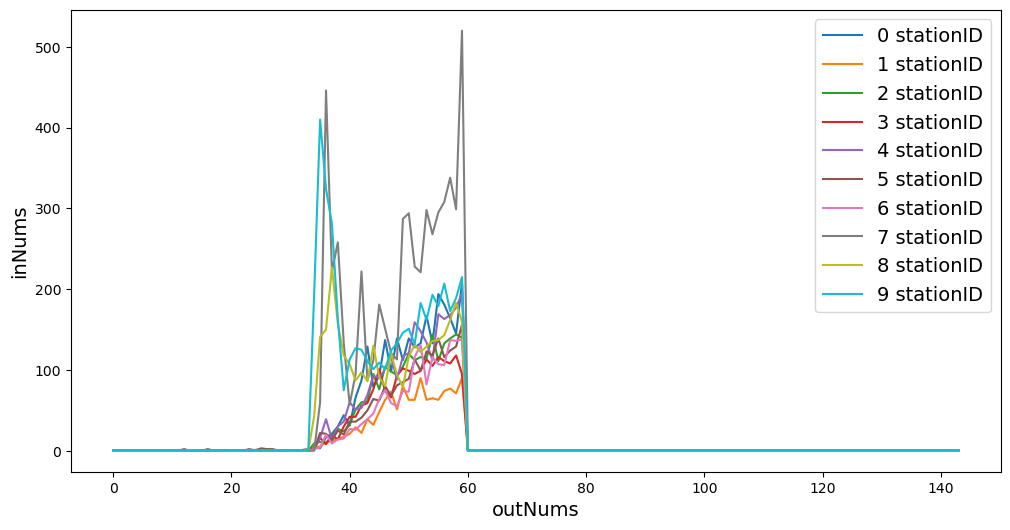

In [161]:
tmp = df_data[df_data.day == 1]
dt = [r for r in range(tmp.loc[tmp.stationID == 0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1, figsize = [12, 6])
plt.ylabel('inNums', fontsize = 14)
plt.xlabel('outNums', fontsize = 14)

for i in range(0, 10):
    plt.plot(dt, tmp.loc[tmp.stationID == i, 'inNums'], label = str(i) + ' stationID')

plt.legend(fontsize = 14)


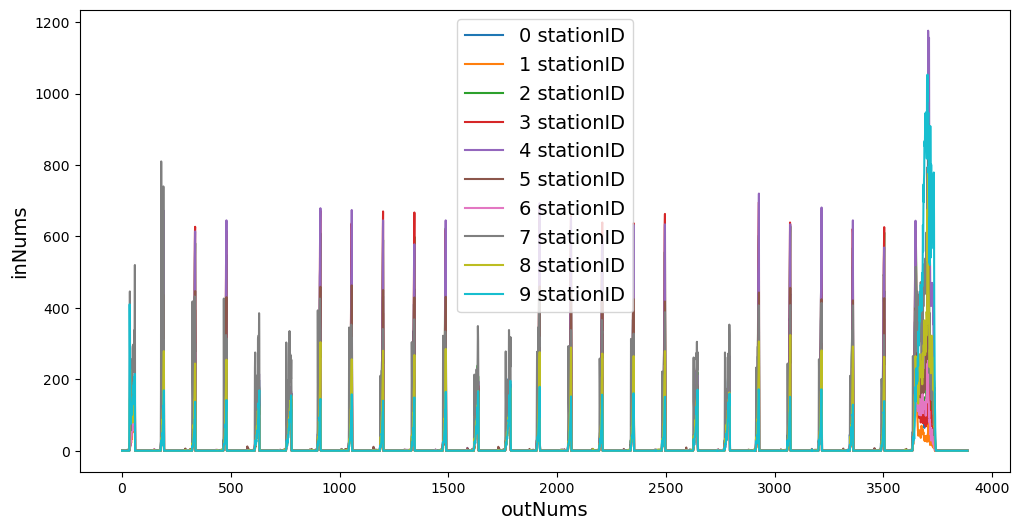

In [163]:
tmp = df_data[df_data.day >= 1]
dt = [r for r in range(tmp.loc[tmp.stationID == 0, 'ten_minutes_in_day'].shape[0])]

plt.figure(1, figsize = [12, 6])
plt.ylabel('inNums', fontsize = 14)
plt.xlabel('outNums', fontsize = 14)

for i in range(0, 10):
    plt.plot(dt, tmp.loc[tmp.stationID == i, 'outNums'], label = str(i) + ' stationID')

plt.legend(fontsize = 14)

In [164]:
Metro_roadMap

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
77,77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78,78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
79,79,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [206]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Activation


In [166]:
X_train.shape

(291600, 8)

In [207]:
def build_model():
    model = Sequential()
    model.add(LSTM(512, input_shape=((X_train.shape[1], 1))))  # 64是LSTM单元数，input_shape是输入数据形状
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))  # 输出层，无激活函数
    return model

In [208]:
model = build_model()
model.compile(loss = 'mae', optimizer = 'adam')

model.fit(X_train, y_train_inNums, epochs=1, batch_size=32)

9113/9113 [==============================] - 550s 59ms/step - loss: 12.5862


In [180]:
X_train

,stationID,time,day,hours_in_day,day_of_week,ten_minutes_in_day,bf_inNums,bf_outNums
0,0,2019-01-01 00:00:00,1,0,1,0,0,0
1,0,2019-01-01 00:10:00,1,0,1,1,0,0
2,0,2019-01-01 00:20:00,1,0,1,2,0,0
3,0,2019-01-01 00:30:00,1,0,1,3,0,0
4,0,2019-01-01 00:40:00,1,0,1,4,0,0
...,...,...,...,...,...,...,...,...
314635,9,2019-01-25 23:10:00,25,23,4,139,0,0
314636,9,2019-01-25 23:20:00,25,23,4,140,0,0
314637,9,2019-01-25 23:30:00,25,23,4,141,0,0
314638,9,2019-01-25 23:40:00,25,23,4,142,0,0


In [1]:
# 666